# Recommender System

Blah blah blah

## Import Libraries and Define File Paths

In [254]:
import scipy
import random
import pandas as pd
import numpy as np
import threadpoolctl
from collections import defaultdict
from implicit.als import AlternatingLeastSquares as ALS
from surprise import AlgoBase, Dataset, accuracy, Reader
from surprise.model_selection import cross_validate, train_test_split, KFold
from surprise import PredictionImpossible
from surprise.prediction_algorithms.knns import KNNBasic, KNNWithMeans, KNNWithZScore
from surprise.prediction_algorithms.matrix_factorization import SVD, SVDpp, NMF
from surprise.prediction_algorithms.co_clustering import CoClustering
from implicit.evaluation import (AUC_at_k,
                                 mean_average_precision_at_k,
                                 ndcg_at_k, precision_at_k)
from implicit.evaluation import train_test_split
import matplotlib.pyplot as plt

dir = "../dataset/utility"

def load_dataset():
    items_df = pd.read_csv(f"{dir}/itemset_preprocessed.csv", low_memory=False)
    items_df.rename(columns={"Unnamed: 0": "ASIN"}, inplace=True)
    items_df.set_index("ASIN", inplace=True)

    df_utility = pd.read_csv(f"{dir}/utility_topn.csv")
    df_utility.set_index("reviewerID", inplace=True)

    reviews_df = pd.read_csv(f"{users_dir}/reviews.csv")
    reviews_df = reviews_df.replace(np.nan, '', regex=True)
    reviews_df["reviewerID"] =  reviews_df["reviewerName"].astype(str) + '_' + reviews_df["reviewerID"].astype(str)
    reviews_df.set_index('reviewerID', inplace=True)

    items_with_info_df = pd.read_csv(f"{items_dir}/itemset_with_info.csv", low_memory=False)
    items_with_info_df.set_index("ASIN", inplace=True)

    diff_asins = list(set(df_utility.columns).difference(set(items_df.index.tolist())))
    df_utility.drop(diff_asins, inplace=True, axis=1)

    diff_asins = list(set(items_df.index.tolist()).difference(set(df_utility.columns)))

    items_df.drop(index=diff_asins, inplace=True)
    print(f"shape of df_utility: {df_utility.shape}")
    print(f"shape of items_df: {items_df.shape}")

    return items_df, df_utility, reviews_df, items_with_info_df

## Load Dataset

In [ ]:
items_df, df_utility, reviews_df, items_with_info_df = load_dataset()

# Try all algorithms
* Neighborhood-based collaborative filtering
* Latent-factor based collaborative filtering
* Content-based collaborative filtering

## Neighborhood-based Collaborative Filtering

From Surprise

In [191]:
melted_user_df = df_utility.copy().reset_index().melt(
    'reviewerID', var_name='ASIN', value_name='rating').dropna()
reader = Reader(rating_scale=(0,5))
dataset = Dataset.load_from_df(melted_user_df, reader)
algos = [KNNBasic(), KNNWithMeans(), SVD()]

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


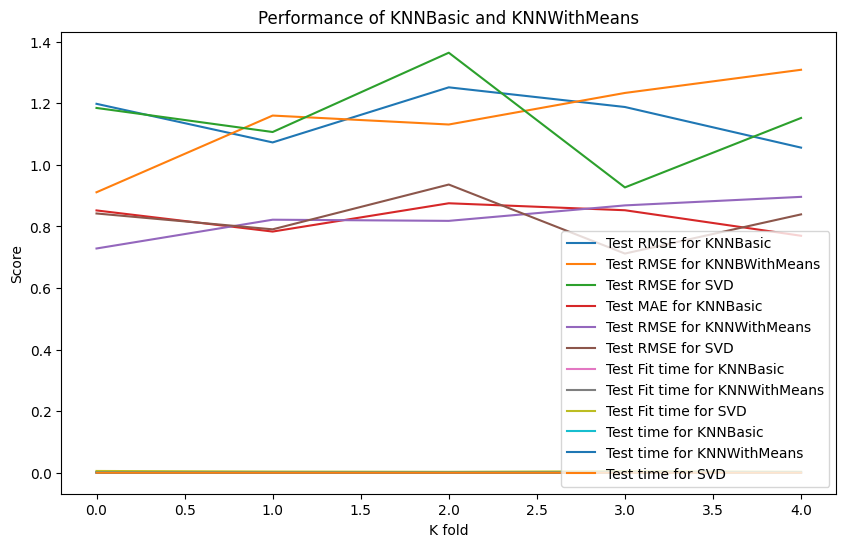

In [200]:
metrics_list = []
for algo in algos:
    metrics = cross_validate(algo, dataset)
    metrics['mean_test_rmse'] = np.mean(metrics['test_rmse'])
    metrics['mean_test_mae'] = np.mean(metrics['test_mae'])
    metrics_list.append(metrics)


k = range(0,5)
plt.figure(figsize=(10, 6))
plt.plot(k, metrics_list[0]['test_rmse'], label='Test RMSE for KNNBasic')
plt.plot(k, metrics_list[1]['test_rmse'], label='Test RMSE for KNNBWithMeans')
plt.plot(k, metrics_list[2]['test_rmse'], label='Test RMSE for SVD')
plt.plot(k, metrics_list[0]['test_mae'], label='Test MAE for KNNBasic')
plt.plot(k, metrics_list[1]['test_mae'], label='Test RMSE for KNNWithMeans')
plt.plot(k, metrics_list[2]['test_mae'], label='Test RMSE for SVD')
plt.plot(k, metrics_list[0]['fit_time'], label='Test Fit time for KNNBasic')
plt.plot(k, metrics_list[1]['fit_time'], label='Test Fit time for KNNWithMeans')
plt.plot(k, metrics_list[2]['fit_time'], label='Test Fit time for SVD')
plt.plot(k, metrics_list[0]['test_time'], label='Test time for KNNBasic')
plt.plot(k, metrics_list[1]['test_time'], label='Test time for KNNWithMeans')
plt.plot(k, metrics_list[2]['test_time'], label='Test time for SVD')
plt.xlabel("K fold")
plt.ylabel("Score")
plt.legend(loc='lower right')
plt.title("Performance of KNNBasic and KNNWithMeans")
plt.show()

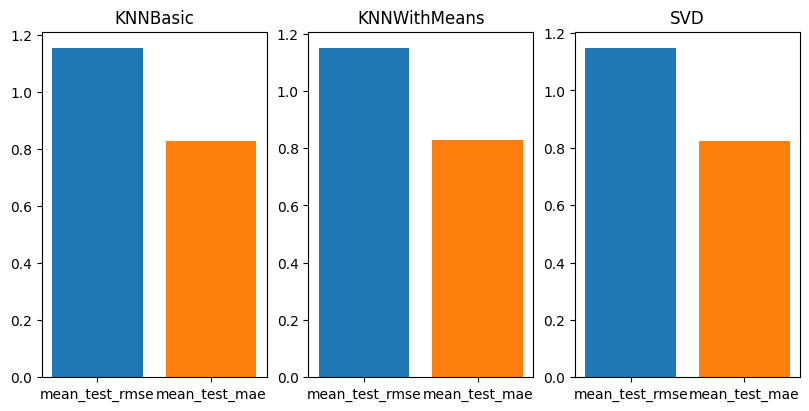

In [203]:
fig, axes = plt.subplots(1, 3, figsize=(8,4), layout='constrained')
method = ["KNNBasic", "KNNWithMeans", "SVD"]
ind = 0
for m in metrics_list:
    for k in m:
        if 'mean' in k:
            axes[ind].bar(k, m[k])
            axes[ind].set_title(method[ind])
    ind += 1
plt.show()

### Precision and Recall

Taken from https://github.com/NicolasHug/Surprise/blob/master/examples/precision_recall_at_k.py

In [204]:
def precision_recall_at_k(predictions, k=10, threshold=3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(
            ((true_r >= threshold) and (est >= threshold))
            for (est, true_r) in user_ratings[:k]
        )

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. We here set it to 0.

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. We here set it to 0.

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    return precisions, recalls

kf = KFold(n_splits=5)

algo_res = []
for algo in algos:
    print(f"computing precision and recall for {algo}")
    res_dict = {'precision': [], 'recall': []}
    for trainset, testset in kf.split(dataset):
        algo.fit(trainset)
        predictions = algo.test(testset)
        precisions, recalls = precision_recall_at_k(predictions, k=5, threshold=4)
        res_dict['precision'].append(sum(prec for prec in precisions.values()) / len(precisions))
        res_dict['recall'].append(sum(rec for rec in recalls.values()) / len(recalls))
    algo_res.append(res_dict)

computing precision and recall for <surprise.prediction_algorithms.knns.KNNBasic object at 0x39a0df650>
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
computing precision and recall for <surprise.prediction_algorithms.knns.KNNWithMeans object at 0x3979c7410>
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
computing precision and recall for <surprise.prediction_al

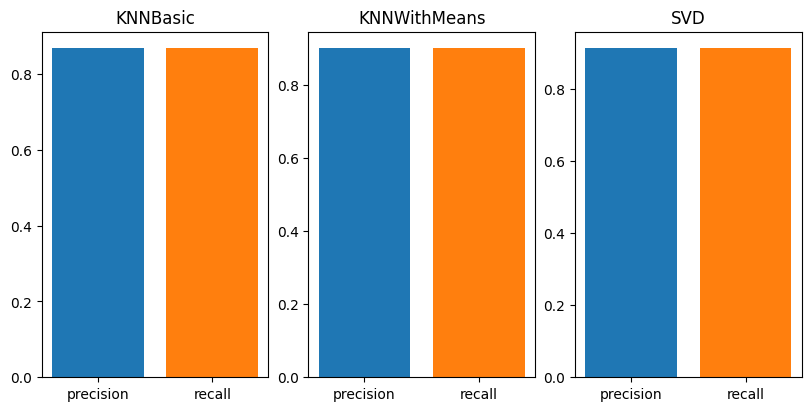

In [206]:
fig, axes = plt.subplots(1, 3, figsize=(8,4), layout='constrained')
method = ["KNNBasic", "KNNWithMeans", "SVD"]
ind = 0
for m in algo_res:
    for k in m:
        axes[ind].bar(k, m[k])
        axes[ind].set_title(method[ind])
    ind += 1
plt.show()

### Get TopN Recommendations for a user

Taken from https://github.com/NicolasHug/Surprise/blob/master/examples/top_n_recommendations.py

In [195]:
def get_top_n(predictions, n=10):
    """Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    """

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

# Than predict ratings for all pairs (u, i) that are NOT in the training set.
testset = trainset.build_anti_testset()
predictions = algos[2].test(testset) # SVD

top_n = get_top_n(predictions, n=10)

# Get the recommended items for each user
recommendations = {}
for uid, user_ratings in top_n.items():
    recommendations[uid] = [iid for (iid, _) in user_ratings]

### Pick out users and explore their history and recommendations

Use SVD because KNN sucks

In [196]:
reviews_df = pd.read_csv(f"{users_dir}/reviews.csv")
reviews_df.set_index('reviewerID', inplace=True)
items_with_info_df = pd.read_csv(f"{items_dir}/itemset_with_info.csv", low_memory=False)
items_with_info_df.set_index("ASIN", inplace=True)

In [197]:
def show_user_history_and_recos(recommendations, user_id):
    """
    Display user purchase history and recommendations
    """
    asin = user_id.split('_')[-1]
    print(f"user history: {user_id}")
    display(reviews_df.loc[[asin]][['ProductName', 'reviewRating']])
    reco_list = recommendations[user_id]
    print("recommended items")
    display(items_with_info_df.loc[reco_list][["category", "name"]])
    print('\n')

In [208]:
user_ids = [x for x in list(recommendations.keys()) if len(x.split('_')[-1]) > 1][:3]
for user_id in user_ids:
    show_user_history_and_recos(recommendations, user_id)

user history: Fadi Shamaan_AH2UZ52SQ4HSIYYUEBYBY6R76JEA


,ProductName,reviewRating
reviewerID,,
AH2UZ52SQ4HSIYYUEBYBY6R76JEA,U.S. Traveler Aviron Bay Expandable Softside L...,3.0
AH2UZ52SQ4HSIYYUEBYBY6R76JEA,Wrangler Smart Luggage Set with Cup Holder and...,1.0
AH2UZ52SQ4HSIYYUEBYBY6R76JEA,"Ultrean Air Fryer, 4.2 Quart Electric Hot Airf...",5.0
AH2UZ52SQ4HSIYYUEBYBY6R76JEA,"Anker Portable Charger, Power Bank, 10,000 mAh...",5.0
AH2UZ52SQ4HSIYYUEBYBY6R76JEA,Amazon Essentials Men's Tech Stretch Tank T-Shirt,4.0
AH2UZ52SQ4HSIYYUEBYBY6R76JEA,"HONITURE Cordless Vacuum Cleaner, 450W 38Kpa S...",5.0
AH2UZ52SQ4HSIYYUEBYBY6R76JEA,Mosuch Stainless Steel Over Door Towel Rack Ba...,3.0
AH2UZ52SQ4HSIYYUEBYBY6R76JEA,"Temdan for iPhone 14 Pro Max Case Waterproof, ...",1.0
AH2UZ52SQ4HSIYYUEBYBY6R76JEA,Corsair VENGEANCE LPX DDR4 RAM 32GB (2x16GB) 3...,5.0


recommended items


,category,name
ASIN,,
B071JS2PFL,children,"dr. brown's milestones options+ sippy spouts, ..."
B0BCDR9M33,computer components,intel core i5-13600k desktop processor 14 (6 p...
B07DBXCN4B,fashion,maliton toiletry bag for men & women | large f...
B016PD563Q,bathroom,perry ellis men's roll sleeve 100% linen butto...
B0BPSGQHLY,living room,"oiahomy large rectangle blanket basket, woven ..."
B0006BAJNG,children,dr. brown's travel and storage baby bottle cap...
B07BKWCYW6,living room,"sades v2020 keyboard and mouse combo, colorful..."
B0BYYS15FM,kitchen,mudeela pots and pans organizer : rack under c...
B0CDNXNM6T,mobile accessories,aureday 88’’ flexible phone tripod with 14.95’...




user history: Richard G_AGXTDTEP5ODOQCRDSOTW3UMFEDBA


,ProductName,reviewRating
reviewerID,,
AGXTDTEP5ODOQCRDSOTW3UMFEDBA,"Cooler Master MWE Gold 850 V2 Full Modular, 85...",5.0
AGXTDTEP5ODOQCRDSOTW3UMFEDBA,PowerColor Fighter AMD Radeon RX 6750 XT 12GB ...,5.0
AGXTDTEP5ODOQCRDSOTW3UMFEDBA,USB Microphone - Professional Recording Microp...,5.0
AGXTDTEP5ODOQCRDSOTW3UMFEDBA,NIVEA MEN Sensitive Calm Liquid Shaving Cream ...,5.0
AGXTDTEP5ODOQCRDSOTW3UMFEDBA,TEAMGROUP AX2 512GB 3D NAND TLC 2.5 Inch SATA ...,5.0
AGXTDTEP5ODOQCRDSOTW3UMFEDBA,SINOSSO Excellent Support Effect Office Chair ...,5.0
AGXTDTEP5ODOQCRDSOTW3UMFEDBA,"Redragon M656 Gainer Wireless Gaming Mouse, 40...",5.0
AGXTDTEP5ODOQCRDSOTW3UMFEDBA,SINOSSO Excellent Support Effect Office Chair ...,5.0
AGXTDTEP5ODOQCRDSOTW3UMFEDBA,Lee Men's Legendary Relaxed Straight Jean,5.0


recommended items


,category,name
ASIN,,
B073V5XZHZ,children,hiccapop hanging diaper organizer for changing...
B07DQCJ84X,living room,"sullivans white ceramic vase set, farmhouse de..."
B000MT4J38,computer components,hp 437939b21 - quad-core intel xeon processor ...
B07CZL6B85,children,"nanobebe baby bottles breastmilk starter set, ..."
B0CLCYH9D1,bathroom,sunny health & fitness row-n-ride squat assist...
B08SSCQH77,personal care,redken all soft conditioner | deeply condition...
B0BTRRNK7T,computer components,"amd ryzen™ 9 7900x3d 12-core, 24-thread deskto..."
B0B1BQNCPR,peripheral devices,"wireless keyboard and mouse combo, 2.4g silent..."
B079RMBCLY,children,huggies baby wipes soft pack soft skin w/vit. ...




user history: Charles Scott_AFMSFDF4URKWUW4KYCOGURAQ2VJQ


,ProductName,reviewRating
reviewerID,,
AFMSFDF4URKWUW4KYCOGURAQ2VJQ,Force of Nature: A Novel,5.0
AFMSFDF4URKWUW4KYCOGURAQ2VJQ,First Lie Wins: A Novel,5.0
AFMSFDF4URKWUW4KYCOGURAQ2VJQ,The Woman in the Window: A Novel,5.0
AFMSFDF4URKWUW4KYCOGURAQ2VJQ,Dune,5.0
AFMSFDF4URKWUW4KYCOGURAQ2VJQ,The Hitchhiker's Guide to the Galaxy,5.0
AFMSFDF4URKWUW4KYCOGURAQ2VJQ,The Billion Dollar Spy: A True Story of Cold W...,5.0
AFMSFDF4URKWUW4KYCOGURAQ2VJQ,The Spy and the Traitor: The Greatest Espionag...,5.0
AFMSFDF4URKWUW4KYCOGURAQ2VJQ,Oil and Marble: A Novel of Leonardo and Michel...,5.0
AFMSFDF4URKWUW4KYCOGURAQ2VJQ,The Spy and the Traitor: The Greatest Espionag...,5.0


recommended items


,category,name
ASIN,,
B08DHRG2X9,computer components,intel® core™ i9-10850k desktop processor 10 co...
B0BXD4VXBR,cleaning material,"59in wall mop with long handle, wjiang wall cl..."
B0BYJMQ76L,car stuff,car pass 14 pcs bling car accessories set for ...
B091XXKZJB,car stuff,"car sun visor vanity mirror, rechargeable make..."
B083QYHX3K,mobile accessories,"ulanzi camera tripod, mini flexible stand with..."
B012H0K7T4,bathroom,"zinus 10 inch cloud memory foam mattress, fibe..."
B0CBP8CL71,living room,"olanly luxury bathroom rugs mat 30x20, extra s..."
B01JKDAN2M,bathroom,pure enrichment® purezone™ air purifier for be...
B01LOM3K90,fashion,men's straight six jeans


## Latent-factor based Collaborative Filtering

### ALS

shape of df_utility: (482, 31348)
shape of items_df: (31348, 3024)


100%|██████████| 63/63 [00:00<00:00, 2352.24it/s]


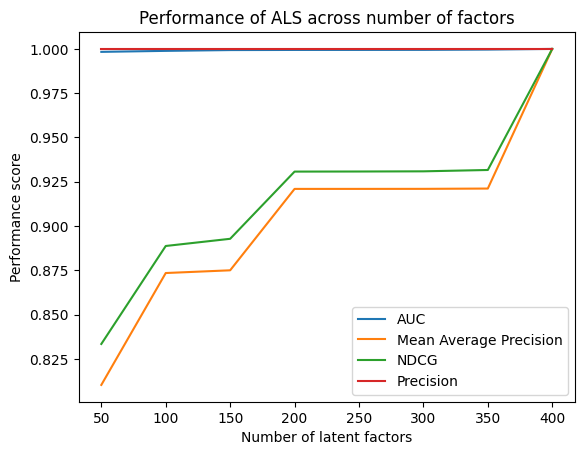

In [261]:
items_df, df_utility, reviews_df, items_with_info_df = load_dataset()
csr_utility = scipy.sparse.csr_matrix(df_utility.fillna(0).values)
!export OPENBLAS_NUM_THREADS=1
threadpoolctl.threadpool_limits(1, "blas")

auc_list = []
mean_ave_precision_list = []
ndcg_list = []
precision_list = []

factors = [50, 100, 150, 200, 250, 300,
           350, 400]

for factor in factors:
    model = ALS(
        factors=factor,
        regularization=0.1,
        alpha=1,
        calculate_training_loss=True,
        use_cg=True,
        iterations=15,
        random_state=143
    )
    model.fit(csr_utility)

    # evaluation
    training_set, test_set = train_test_split(
        csr_utility,
        train_percentage=0.85,
        random_state=143
    )
    auc = AUC_at_k(model,training_set,test_set,
                K=len(df_utility), show_progress=True)
    mean_ave_precision = mean_average_precision_at_k(model, training_set,
                test_set, K=len(df_utility), show_progress=True)
    ndcg = ndcg_at_k(model, training_set, test_set,
                K=len(df_utility), show_progress=True)
    precision = precision_at_k(model, training_set,
                test_set, K=len(df_utility), show_progress=True)
    auc_list.append(auc)
    mean_ave_precision_list.append(mean_ave_precision)
    ndcg_list.append(ndcg)
    precision_list.append(precision)

plt.plot(factors, auc_list, label='AUC')
plt.plot(factors, mean_ave_precision_list, label='Mean Average Precision')
plt.plot(factors, ndcg_list, label='NDCG')
plt.plot(factors, precision_list, label='Precision')
plt.xlabel('Number of latent factors')
plt.ylabel('Performance score')
plt.title("Performance of ALS across number of factors")
plt.legend()
plt.show()

In [262]:
model = ALS(
    factors=factor,
    regularization=0.1,
    alpha=1,
    calculate_training_loss=True,
    use_cg=True,
    iterations=15,
    random_state=143
)
model.fit(csr_utility)

  0%|          | 0/15 [00:00<?, ?it/s]

100%|██████████| 15/15 [00:02<00:00,  5.68it/s, loss=6.57e-6]


In [263]:
userids = random.sample(range(0, len(df_utility)), 10)
ids, scores = model.recommend(userids, csr_utility[userids])
recommendations = [(x, y, z) for x, y, z in zip(userids, ids, scores)]

try:
    reviews_df.set_index('reviewerID', inplace=True)
except:
    pass

def show_user_history_and_recos_als(df_utility, recommendations, reviews_df, items_with_info_df):
    """
    Display user purchase history and recommendations
    """
    for user_ind, reco_ids, scores in recommendations:
        reviewer_id = df_utility.iloc[user_ind, :].name
        print(f"user history: {reviewer_id}")
        display(reviews_df.loc[reviewer_id][['ProductName', 'reviewRating']])
        print("recommendations")
        display(items_with_info_df.iloc[reco_ids, :][["category", "name"]])
        print("scores")
        for reco_id, score in zip(reco_ids, scores):
            print((reco_id, score))
        print('\n')
show_user_history_and_recos_als(df_utility, recommendations, reviews_df, items_with_info_df)

user history: Amanda_


,ProductName,reviewRating
reviewerID,,
Amanda_,"Andalou Naturals Toner, 1000 Roses Biome Balan...",5.0
Amanda_,Mario Badescu Aloe Vera Toner for Dry and Sens...,5.0
Amanda_,Simple Kind to Skin Facial Toner Soothing 200ml,5.0
Amanda_,"#4 Cone Coffee Filter 8-12 cup, Unbleached Nat...",5.0
Amanda_,ELIVED UL Listed TV Wall Mount for Most 37-82 ...,5.0
Amanda_,"Cuisinart 12-Piece Kitchen Knife Set, Multicol...",5.0
Amanda_,"Sunzel Nunaked Workout Leggings for Women, Tum...",5.0
Amanda_,"ATTITUDE Baby Fabric Softener, Plant and Miner...",5.0
Amanda_,"Seventh Generation EasyDose Laundry Detergent,...",5.0


recommendations


,category,name
ASIN,,
B0CKS8DVXW,children,"hapgo girls beauty salon set, doll head hair s..."
B002GEJYSM,children,"nuby standard neck tinted feeding nurser, 1 co..."
B0CTYKY5D2,children,britax marathon clicktight convertible car sea...
B09XFFHDMD,children,"3 diapers, reborn baby 11-12"" clothes dolls, b..."
B09S66BQ1S,personal care,"focallure 2 pcs mineral cream contour stick,mo..."
B08465GD4W,children,"kidsembrace high back booster car seat, disney..."
B0BRSXSRYQ,kitchen,home hero 2 pcs vegetable knife with sheath - ...
B001KYVVRG,personal care,l'oréal paris makeup infallible 8 hour hydrati...
B0CK562MYF,personal care,neutrogena gentle oil-free eye makeup remover ...


scores
(29635, 0.00013020262)
(29880, 5.217851e-05)
(30467, 4.9445778e-05)
(31129, 4.5802444e-05)
(20682, 4.160311e-05)
(30514, 3.5438105e-05)
(26941, 3.441237e-05)
(20742, 3.415998e-05)
(20737, 3.1654723e-05)
(27953, 3.0882657e-05)


user history: LadyRN_AHYU3PBS2HAOM27MF7CCY4NQMC7A


,ProductName,reviewRating
reviewerID,,
LadyRN_AHYU3PBS2HAOM27MF7CCY4NQMC7A,"SAMSUNG Galaxy Tab S6 Lite 10.4"" 128GB Android...",5.0
LadyRN_AHYU3PBS2HAOM27MF7CCY4NQMC7A,"USB C Charger Block 2Pack, iPhone 14 13 12 Cha...",5.0
LadyRN_AHYU3PBS2HAOM27MF7CCY4NQMC7A,THE FACE SHOP Rice Water,5.0
LadyRN_AHYU3PBS2HAOM27MF7CCY4NQMC7A,Womens Classic Coat Lapel Collar Open Front Be...,5.0
LadyRN_AHYU3PBS2HAOM27MF7CCY4NQMC7A,PAVOI 14K Gold Plated Solid 925 Sterling Silve...,5.0
LadyRN_AHYU3PBS2HAOM27MF7CCY4NQMC7A,Hydro Flask Stainless Steel Standard Mouth Wat...,5.0
LadyRN_AHYU3PBS2HAOM27MF7CCY4NQMC7A,Amazon Essentials Men's Crewneck Sweater (Avai...,5.0
LadyRN_AHYU3PBS2HAOM27MF7CCY4NQMC7A,Flat Top Kabuki Foundation Brush By KESHIMA - ...,5.0
LadyRN_AHYU3PBS2HAOM27MF7CCY4NQMC7A,"e.l.f. Monochromatic Multi Stick, Luxuriously ...",4.0


recommendations


,category,name
ASIN,,
B0BJC3QTSB,children,"magnet toys for 3 year old boys & girls, monte..."
B01LEN35SK,children,"caboo tree free bamboo baby wipes, eco friendl..."
B07XWQXPDT,bedroom,3.5x5 inch do not flush rules bathroom sign ~ ...
B09WHRC776,children,"diono radian 3r, 3-in-1 convertible car seat, ..."
B01739UNYI,kitchen,1.6cf commercial stackable steamer microwave o...
B0CBLD1P6W,children,oxford baby everlee modern high arch 3-in-1 co...
B09Y1XCTCV,children,"action figures set, 5 pcs action figures toys,..."
B0CD7FLZBW,travel essentials,"water bottle bag for stanley 40 oz tumbler, bo..."
B0BLYX2ZZC,children,"bedside bassinet, bedside sleeper, bedside cri..."


scores
(28577, 0.012142665)
(30283, 0.011409121)
(462, 0.00803289)
(30497, 0.006473845)
(27077, 0.0064258566)
(30794, 0.005768713)
(28415, 0.0054993033)
(24962, 0.0052991984)
(30801, 0.0051730685)
(25143, 0.0033805752)


user history: AlexAlex_


,ProductName,reviewRating
reviewerID,,
AlexAlex_,SAMSUNG Odyssey G50A Series 32-Inch WQHD (2560...,5.0
AlexAlex_,Alienware AW2523HF Gaming Monitor - 24.5-inch ...,5.0
AlexAlex_,"SAMSUNG 34"" Odyssey G5 Ultra-Wide Gaming Monit...",5.0
AlexAlex_,"Auto Keystone Mini Portable Projector, 4K/200 ...",5.0
AlexAlex_,"VASAGLE 6-Tier Tall Bookshelf, Narrow Bookcase...",5.0
AlexAlex_,"Yozai Men's Winter Coat, Warm Jackets for Mens...",3.0
AlexAlex_,Lugz Men's Lear Classic Fashion Sneaker,5.0
AlexAlex_,Mattel WWE Action Figure Damian Priest 6-inch ...,5.0
AlexAlex_,"Avengers Marvel Iron Spider 6""-Scale Marvel Su...",1.0


recommendations


,category,name
ASIN,,
B0CD7FLZBW,travel essentials,"water bottle bag for stanley 40 oz tumbler, bo..."
B00EDKT4UU,children,wubbanub infant pacifier - tiger
B0BJC3QTSB,children,"magnet toys for 3 year old boys & girls, monte..."
B0CLK6ZXYK,children,toddler travel suitcase seat with safety anti-...
B0CB64WJ9R,kitchen,howhic velvet chair covers for dining room set...
B07X5VRCVZ,children,baby bed crib screws and bolts hardware kit 16...
B0C1NF1N4H,office supplies,auvon innovation donut pillow hemorrhoids scie...
B08R716VV3,children,binzkbb light magnetic tiles building blocks f...
B01739UNYI,kitchen,1.6cf commercial stackable steamer microwave o...


scores
(24962, 0.045841813)
(31337, 0.035296198)
(28577, 0.03244623)
(30564, 0.019641124)
(28259, 0.018929286)
(30751, 0.015214948)
(24031, 0.014784822)
(28546, 0.0145378485)
(27077, 0.009515172)
(28415, 0.009374741)


user history: Ann_


,ProductName,reviewRating
reviewerID,,
Ann_,ELEMIS Soothing Apricot Toner | Alcohol-Free C...,5.0
Ann_,"Simple Designs LT3302-SGE 8"" Contemporary 1 Li...",5.0
Ann_,The Princess and the Grilled Cheese Sandwich (...,5.0
Ann_,Powerless (The Powerless Trilogy),5.0
Ann_,"Japan Knives, Viking Knife with Sheath, Meat C...",5.0
Ann_,Come Sundown: A Novel,5.0
Ann_,Vision Home Natural Pinch Pleated Full Blackou...,5.0
Ann_,"VRPEFIT Smart Watch for Men Women, Activity Fi...",4.0
Ann_,Come Sundown: A Novel,5.0


recommendations


,category,name
ASIN,,
B01LEN35SK,children,"caboo tree free bamboo baby wipes, eco friendl..."
B09WHRC776,children,"diono radian 3r, 3-in-1 convertible car seat, ..."
B0CLK6ZXYK,children,toddler travel suitcase seat with safety anti-...
B09Y1XCTCV,children,"action figures set, 5 pcs action figures toys,..."
B0C2Z23611,children,"7pcs superhero action figures toys, collectibl..."
B0CB64WJ9R,kitchen,howhic velvet chair covers for dining room set...
B01739UNYI,kitchen,1.6cf commercial stackable steamer microwave o...
B07SK6ZFLM,travel essentials,"airplane foot hammock (memory foam), perfect a..."
B09WQWTHVZ,kitchen,"microwave oven rack, expandable microwave stan..."


scores
(30283, 0.018598065)
(30497, 0.012635542)
(30564, 0.010613593)
(28415, 0.007907065)
(28361, 0.007905686)
(28259, 0.0076472787)
(27077, 0.005069524)
(25143, 0.0027274182)
(27268, 0.0019189604)
(26472, 0.001877577)


user history: Diane_


,ProductName,reviewRating
reviewerID,,
Diane_,0.015% Hypochlorous Acid Spray with Optimal PH...,5.0
Diane_,COSRX Snail Mucin 96% Power Repairing Essence ...,5.0
Diane_,"Emeril Lagasse Everyday 360 Air Fryer, 360° Qu...",5.0
Diane_,Keurig K-Elite Single-Serve K-Cup Pod Coffee M...,5.0
Diane_,Skechers Women's Parties-Mate Oxford Shoes,5.0
Diane_,HeSaYep Women's High Waisted Sweatpants Workou...,5.0
Diane_,"Portable Washing Machine for Apartments, Dorms...",5.0
Diane_,Brother LC4063PK 3 Pack of Standard Yield Cyan...,1.0
Diane_,"Emeril Lagasse Everyday 360 Air Fryer, 360° Qu...",5.0


recommendations


,category,name
ASIN,,
B08R716VV3,children,binzkbb light magnetic tiles building blocks f...
B07X5VRCVZ,children,baby bed crib screws and bolts hardware kit 16...
B0C1NF1N4H,office supplies,auvon innovation donut pillow hemorrhoids scie...
B09YVRBHYX,children,"babyganics size 2, 152 count, absorbent, breat..."
B073VRFM5G,children,cosco finale dx 2-in-1 combination booster car...
B0CL98Q9NN,kitchen,"sharp 1.4-cu. ft. countertop microwave oven, s..."
B07Y5X7N27,children,"graco modes nest travel system, includes baby ..."
B0CLK6ZXYK,children,toddler travel suitcase seat with safety anti-...
browserWarning?0=%2Fplayer%2Falbums%2FB0BBB1WVMD&1=player%2Falbums%2FB0BBB1WVMD&subView=music&useHorizonte=true,children,NaN


scores
(28546, 0.0185022)
(30751, 0.008115483)
(24031, 0.007327684)
(31107, 0.007154952)
(30618, 0.0035996502)
(27181, 0.002936571)
(30509, 0.002548419)
(30564, 0.0024123983)
(29700, 0.0023471573)
(30915, 0.0021631382)


user history: MS_


,ProductName,reviewRating
reviewerID,,
MS_,Eclat Skincare Rose Water Toner for Face - Por...,5.0
MS_,ZAGG InvisibleShield Glass+ Screen Protector –...,5.0
MS_,Rowenta PurePop Handheld Steamer for Clothes 1...,5.0
MS_,"Garmin Drive™ 53 GPS Navigator, High-Resolutio...",3.0
MS_,O'Keeffe's Skin Repair Body Lotion and Dry Ski...,5.0
MS_,"Cordking for iPhone 13 Case, iPhone 14 Case, S...",5.0
MS_,"Amazon Essentials Reusable Face Cover, Black (...",5.0
MS_,Best of Enemies Vol. 2: A History of US and Mi...,5.0
MS_,Hydro Flask Trail Series Lightweight Water Bot...,5.0


recommendations


,category,name
ASIN,,
browserWarning?0=%2Fplayer%2Falbums%2FB0BBB1WVMD&1=player%2Falbums%2FB0BBB1WVMD&subView=music&useHorizonte=true,children,NaN
B08R716VV3,children,binzkbb light magnetic tiles building blocks f...
B0CBMR1PYQ,children,montessori sensory toys for toddlers 1-3 - tra...
B08CWBW3MX,children,"cub portable bassinet in beige, multi-use baby..."
B0BN1GGDFZ,children,lol surprise mix & make birthday cake tots wit...
B0BVW42WT6,children,"deao baby doll stroller set with 13 inch doll,..."
B00OPUP00G,children,polycal - 14.1 oz can
B07X5VRCVZ,children,baby bed crib screws and bolts hardware kit 16...
B073VRFM5G,children,cosco finale dx 2-in-1 combination booster car...


scores
(29700, 0.014531425)
(28546, 0.0126333535)
(28868, 0.0085493475)
(30789, 0.0083972365)
(29680, 0.0074735666)
(29731, 0.0066741956)
(30169, 0.0049537243)
(30751, 0.004583396)
(30618, 0.0033374093)
(29577, 0.003067247)


user history: Kristina_


,ProductName,reviewRating
reviewerID,,
Kristina_,Kenneth Cole REACTION Out of Bounds Lightweigh...,5.0
Kristina_,Gourmetop Kitchen Knife Set with No Drilling M...,5.0
Kristina_,"Red Volcano Textured Ceramic Nonstick, 7"" & 10...",4.0
Kristina_,Men's Underwear Covered Waistband Boxer Briefs...,5.0
Kristina_,Yaheetech Lift Top Coffee Table with Hidden Co...,5.0
Kristina_,Ulefone Note 16 Pro(16GB+256GB) Unlocked Phone...,4.0
Kristina_,Gloria Vanderbilt Women's Amanda Pull on High ...,4.0
Kristina_,Tide Ultra OXI Power PODS with Odor Eliminator...,5.0
Kristina_,"Alba Botanica More Moisture Conditioner, Cocon...",5.0


recommendations


,category,name
ASIN,,
B0CLK6ZXYK,children,toddler travel suitcase seat with safety anti-...
B09WHRC776,children,"diono radian 3r, 3-in-1 convertible car seat, ..."
B0CB64WJ9R,kitchen,howhic velvet chair covers for dining room set...
B07X5VRCVZ,children,baby bed crib screws and bolts hardware kit 16...
B07SK6ZFLM,travel essentials,"airplane foot hammock (memory foam), perfect a..."
B07XWQXPDT,bedroom,3.5x5 inch do not flush rules bathroom sign ~ ...
B0CBMR1PYQ,children,montessori sensory toys for toddlers 1-3 - tra...
B01LEN35SK,children,"caboo tree free bamboo baby wipes, eco friendl..."
B085NLFY9F,kitchen,taylor swoden 12-cup programmable coffee maker...


scores
(30564, 0.020599037)
(30497, 0.013876874)
(28259, 0.012796996)
(30751, 0.010182908)
(25143, 0.010114038)
(462, 0.009873779)
(28868, 0.009259545)
(30283, 0.009133246)
(26472, 0.006594075)
(28361, 0.0063550007)


user history: Corey Smith_AEPBOORKRFPG6LBDP756XA7O37XQ


,ProductName,reviewRating
reviewerID,,
Corey Smith_AEPBOORKRFPG6LBDP756XA7O37XQ,"Portable Travel Washing Machine, 10L Portable ...",5.0
Corey Smith_AEPBOORKRFPG6LBDP756XA7O37XQ,Tajsoon 9 Tier Tree Bookshelf with Drawer Book...,5.0
Corey Smith_AEPBOORKRFPG6LBDP756XA7O37XQ,"Freexployer Small Bookshelf, 3 Tier Vintage In...",5.0
Corey Smith_AEPBOORKRFPG6LBDP756XA7O37XQ,"LENNYVILLNA Dresser for Bedroom, Tall Dresser ...",5.0
Corey Smith_AEPBOORKRFPG6LBDP756XA7O37XQ,"Boonatu Dresser for Bedroom with 6 Drawers, Wh...",5.0
Corey Smith_AEPBOORKRFPG6LBDP756XA7O37XQ,BZZCAM WiFi Hidden Spy Camera Mini Wireless Na...,5.0
Corey Smith_AEPBOORKRFPG6LBDP756XA7O37XQ,Comfort Spaces Grey Queen Comforter Set - 3 Pi...,5.0
Corey Smith_AEPBOORKRFPG6LBDP756XA7O37XQ,"Aobafuir Rattan Nightstand, 2 Drawer Dresser f...",5.0
Corey Smith_AEPBOORKRFPG6LBDP756XA7O37XQ,Fixwal Nightstands Set of 2 with Charging Stat...,5.0


recommendations


,category,name
ASIN,,
B0BNHC2MR8,bedroom,"cvhouse butterfly bedding set,butterfly comfor..."
B0CJJ98WS2,bedroom,geniospin 7-piece queen comforter set - solid ...
B08CRJYM55,bedroom,cozylux queen bed in a bag 7-pieces comforter ...
B0BP6D1LPW,bedroom,bedsure duvet cover king size - king duvet cov...
B0CC6DJQMW,bedroom,"gorilla grip bed sheet straps, adjustable elas..."
B0B2DG8QRL,bedroom,utopia bedding 100% cotton blanket (king size ...
B0B4ZCYXMX,bedroom,wongs bedding cars toddler bedding set cotton ...
B0CC6N7XR9,bedroom,sweet jojo designs woodland forest animals boy...
B0CH9Y8CBQ,bedroom,"wongs bedding grey comforter set queen, revers..."


scores
(9, 0.0)
(8, 0.0)
(7, 0.0)
(6, 0.0)
(5, 0.0)
(4, 0.0)
(3, 0.0)
(2, 0.0)
(1, 0.0)
(0, 0.0)


user history: Juan_


,ProductName,reviewRating
reviewerID,,
Juan_,"Gillette Mach3 Razor Refills for Men, 15 Razor...",5.0
Juan_,ASUS AM4 TUF Gaming X570-Plus (Wi-Fi) AM4 Zen ...,5.0
Juan_,"Rockford Fosgate P1683 Punch 6""x8"" 3-Way Coaxi...",5.0
Juan_,Best Choice Products Upholstered Sectional Sof...,5.0
Juan_,"Forty4 Wireless Gaming Controller, Game Contro...",5.0
Juan_,"Smart Watch, Luoba 1.69'' Full Touch Answer/Ma...",5.0
Juan_,Marvel Hasbro Legends Series Venom 6-inch Coll...,5.0
Juan_,Ban Original Unscented 24-hour Invisible Antip...,5.0
Juan_,Corsair Flash Survivor Stealth 64GB USB 3.0 Fl...,5.0


recommendations


,category,name
ASIN,,
B07F6VXB15,children,"dr. brown's designed to nourish, fresh firsts ..."
B0BP2C2HW8,children,kids toys stem board games - logic road builde...
B07F6G42R9,children,"luvs (luvsd) diapers size 6, 124 count - luvs ..."
B09BW2XYMR,children,mattel disney pixar cars transforming mack pla...
B00XH96EEC,personal care,clinique take the day off makeup remover for l...
B0C731QWPG,children,"chandler crib to full-size bed conversion kit,..."
B0C5DVH4K6,children,toys gifts for toddler boys girls ages 2 3 4 5...
B0CK562MYF,personal care,neutrogena gentle oil-free eye makeup remover ...
B08TR9428W,children,disney encanto isabela fashion doll with dress...


scores
(31325, 5.9571117e-05)
(28721, 5.9022568e-05)
(31196, 5.3014606e-05)
(29372, 5.086884e-05)
(20720, 4.472211e-05)
(30918, 4.4526532e-05)
(28709, 4.4070184e-05)
(20737, 4.2181462e-05)
(29777, 3.772881e-05)
(30144, 3.663171e-05)


user history: Sam_


,ProductName,reviewRating
reviewerID,,
Sam_,"ANUA Heartleaf 77 Toner Pad 70 Sheets, PHA Dea...",5.0
Sam_,MSI 27” FHD (1920 x 1080) Non-Glare with Super...,5.0
Sam_,ASUS ROG Herculx Graphics Card Anti-Sag Holder...,4.0
Sam_,HeSaYep Women's High Waisted Sweatpants Workou...,5.0
Sam_,Amazon Basics 3-Piece Non-Stick Frying Pan Set...,5.0
Sam_,Rachael Ray Create Delicious Deep Nonstick Fry...,3.0
Sam_,Wireless Bluetooth Karaoke Microphone for Kids...,4.0
Sam_,"OontZ Angle 3 Bluetooth Speaker, up to 100 ft ...",5.0
Sam_,"MAWODE Bluetooth Speakers, T10 Waterproof Spea...",5.0


recommendations


,category,name
ASIN,,
B0749KYFXX,kitchen,hotec stainless steel kitchen tongs set of 2 -...
B0C2Z23611,children,"7pcs superhero action figures toys, collectibl..."
B09WHRC776,children,"diono radian 3r, 3-in-1 convertible car seat, ..."
browserWarning?0=%2Fplayer%2Falbums%2FB0BBB1WVMD&1=player%2Falbums%2FB0BBB1WVMD&subView=music&useHorizonte=true,children,NaN
B0BVW42WT6,children,"deao baby doll stroller set with 13 inch doll,..."
B0BLYX2ZZC,children,"bedside bassinet, bedside sleeper, bedside cri..."
B0C1NF1N4H,office supplies,auvon innovation donut pillow hemorrhoids scie...
B07SK6ZFLM,travel essentials,"airplane foot hammock (memory foam), perfect a..."
B01LEN35SK,children,"caboo tree free bamboo baby wipes, eco friendl..."


scores
(26090, 0.024673423)
(28361, 0.02089088)
(30497, 0.019443085)
(29700, 0.01203048)
(29731, 0.011046659)
(30801, 0.0106084775)
(24031, 0.009086939)
(25143, 0.007959155)
(30283, 0.0068839537)
(26472, 0.0051492956)




## Content-based